#RNN ile Havayolu Yolcu Sayısı Tahmini

1- Problem

2- Veriyi Anlamak

3- Veriyi Hazırlamak

4- Modelleme

5- Değerlendirme - Evaluation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import kagglehub

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Verisetini yükleme

df = pd.read_csv("/international-airline-passengers.csv")
df.columns = ["Month", "Passengers"]
df.head()


,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail() # dizinin sonundaki veriyi gösterir ve sondaki veri hatalı!

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.dtypes # veri tiplerini gösterir ve month değişkeni tarih olamsı gerekirken obje olarak dönüyor.

,0
Month,object
Passengers,float64


In [9]:
df = df[:144] # sondaki bozuk veriden kurtulduk.
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [10]:
df["Month"] = pd.to_datetime(df["Month"]) # Tarihe dönüştürdük.
df.dtypes

,0
Month,datetime64[ns]
Passengers,float64


In [11]:
df.index = df["Month"] # Tarihe göre index ayarlandı.
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [12]:
df.drop("Month", axis=1, inplace=True) # Tarihe göre index ayarlandı.
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: title={'center': 'Monthly International Airline Passengers'}, xlabel='Month'>

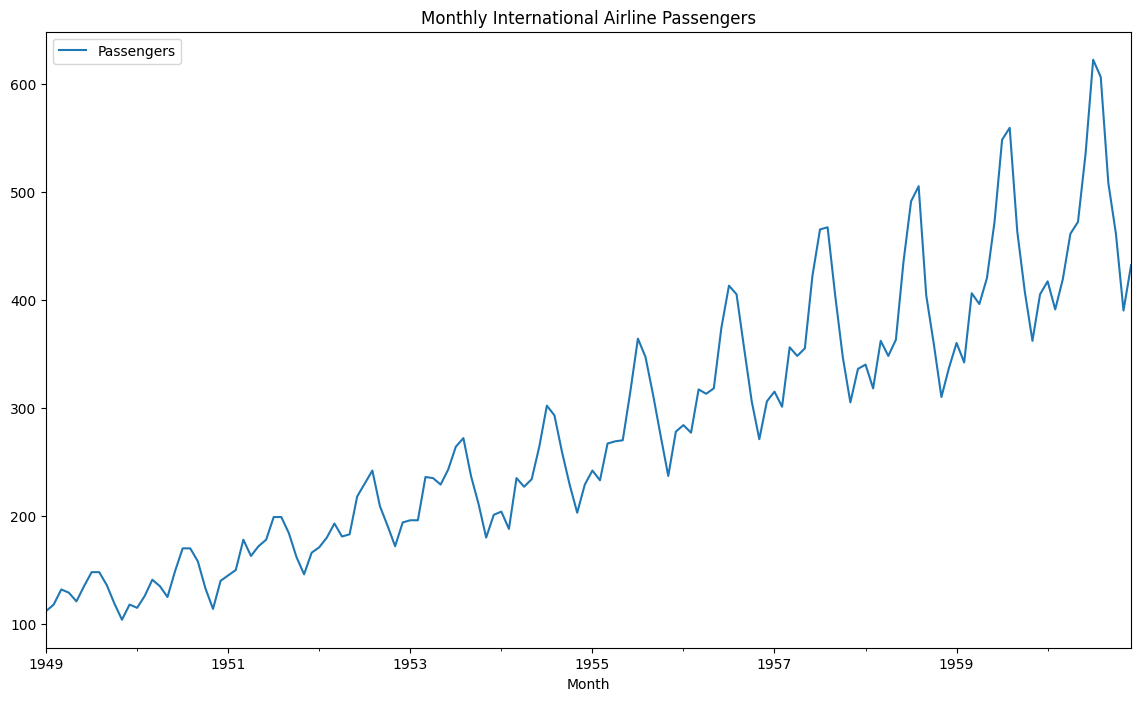

In [13]:
result_df = df.copy()
df.plot(figsize=(14,8), title="Monthly International Airline Passengers")

In [14]:
data = df["Passengers"].values # numpy a dönüştürüldü
data = data.astype('float32') # float32 ye dönüştürüldü
type(data[0])

numpy.float32

In [15]:
# train ve test set oluşturma

def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [16]:
train, test, position = split_data(data, 0.33)
print(train.shape, test.shape)

(96,) (48,)


In [17]:
# Normalizasyon 0-1

scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train.reshape(-1, 1)) # Reshape train data to 2D
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test.reshape(-1, 1))   # Reshape test data to 2D

train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [18]:
# tahmin için bir önceki ayın değerleriyle bir feature oluturuyoruz.

def create_feature(data, lookback):
  x, y = [], []
  for i in range(lookback, len(data)):
    x.append(data[i-lookback:i, 0])
    y.append(data[i, 0])
  return np.array(x), np.array(y)

In [24]:
lookback = 1

x_train, y_train = create_feature(train, lookback)
x_test, y_test = create_feature(test, lookback)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(95, 1, 1) (95,)
(47, 1, 1) (47,)


In [25]:
# Modelleme

model = Sequential()

model.add(SimpleRNN(units=50, activation='relu', input_shape=( x_train.shape[1], lookback)))

model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Optimizasyon ve değerlendirma metrikler

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', mode="min", save_weights_only=False, save_best_only=True, verbose=1)]

In [27]:
history = model.fit(x_train, y_train, epochs=50, batch_size=1, validation_data=(x_train, y_train), callbacks=callbacks, shuffle=False)

Epoch 1/50
74/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 1: val_loss improved from inf to 0.02341, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 2/50
75/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - mse: 0.0250
Epoch 2: val_loss improved from 0.02341 to 0.01196, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 3/50
79/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - mse: 0.0130
Epoch 3: val_loss improved from 0.01196 to 0.00774, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 4/50
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 4: val_loss improved from 0.00774 to 0.00685, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/50
71/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mse: 0.0056
Epoch 5: val_loss improved from 0.00685 to 0.00619, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/50
76/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mse: 0.0047
Epoch 6: val_loss did not improve from 0.00619
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/50
78/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mse: 0.0050
Epoch 7: val_loss improved from 0.00619 to 0.00568, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 8/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - mse: 0.0045
Epoch 8: val_loss did not improve from 0.00568
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 9/50
80/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mse: 0.0036
Epoch 9: val_loss did not improve from 0.00568
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 10/50
74/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 10: val_loss improved from 0.00568 to 0.00562, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 11/50
79/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mse: 0.0033
Epoch 11: val_loss did not improve from 0.00562
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 12/50
76/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 12: val_loss did not improve from 0.00562
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 13/50
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - mse: 0.0027
Epoch 13: val_loss did not improve from 0.00562
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 13: early stopping


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train RMSE:  21633608.05389363
Test RMSE:  43647633.76917195


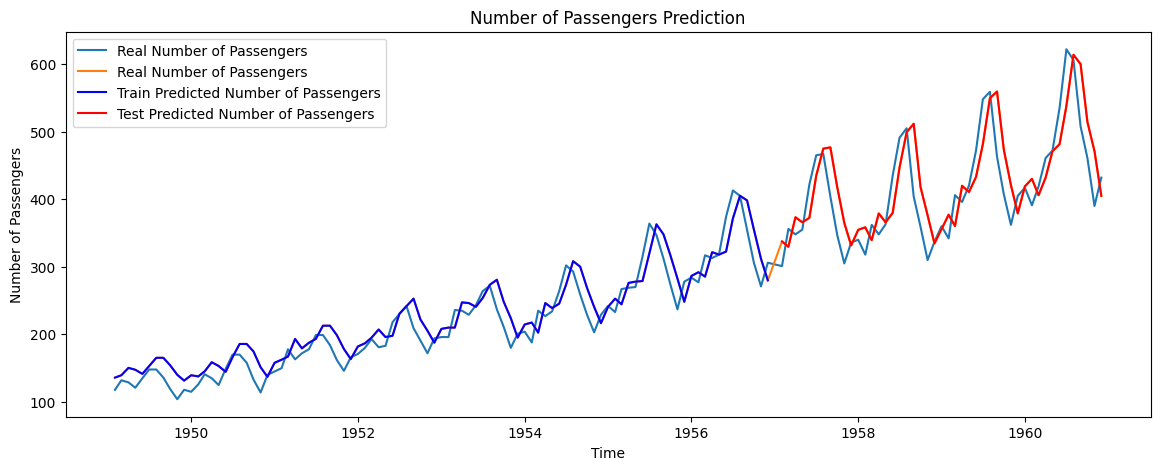

In [31]:
# Evaluation

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = scaler_train.inverse_transform(train_predict)
y_train = scaler_train.inverse_transform(y_train.reshape(-1, 1)) # Reshape y_train to 2D for inverse_transform

test_predict = scaler_test.inverse_transform(test_predict)
y_test = scaler_test.inverse_transform(y_test.reshape(-1, 1)) # Reshape y_test to 2D for inverse_transform

# train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict)) # Remove [0] indexing
print("Train RMSE: ", train_rmse)

# test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict)) # Remove [0] indexing
print("Test RMSE: ", test_rmse)

df.describe().T

# Change 'result.df' to 'result_df'
train_prediction_df = result_df[lookback:position]  # Use result_df instead of result.df
train_prediction_df["Predicted"] = train_predict
# Adjust the index of test_prediction_df to match the length of test_predict
test_prediction_df = result_df[position + lookback:]  # Adjust index for test data
test_prediction_df["Predicted"] = test_predict
result_df = pd.concat([train_prediction_df, test_prediction_df])
result_df.head()

# veri görselleştirme

plt.figure(figsize=(14,5))
plt.plot(result_df, label="Real Number of Passengers")
plt.plot(train_prediction_df["Predicted"], color='blue', label="Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color='red', label="Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()